# Quality of food offered in the World

In this notebook we explore the [Open Food Facts database](https://world.openfoodfacts.org/). After loading, observing and cleaning the data in part 1, we start our analysis in part 2 with the aim of updating our readme to see if what we wanted to do is feasable. In this second part, we uncover insights about the nutritional quality of food consumed around the world. Food habits vary among countries, we would like to point out which areas offer the least healthy options by observing the products offered there.

More particularly, we will look at the following points:
* How restrictions concerning additives in different countries affects the presence of these substances in foods around the world. We'll also look at whether banning an ingredient in a certain country reduces its presence in other places?
* We will consider the amounts of sugar and fat availble in foods around the world.
* We will look at how widespread ingredients like palm oil are.

# 1. Loading, Observing and Cleaning the Data.

## Loading the data and imports.

First, we import the necessary packages for our analysis. 

In [3]:
import pandas as pd
import numpy as np
import json
import folium as folium
from wordcloud import WordCloud
from langdetect import detect_langs
from matplotlib import pyplot

from ast import literal_eval
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# make figures larger for better viewing
plt.rc('figure', figsize=[18,10])
plt.style.use('fivethirtyeight')

Then, we load the data and take a first look at it.

In [5]:
data_path = './data/'
open_food_facts_path = data_path + 'en.openfoodfacts.org.products.csv'

df = pd.read_csv(open_food_facts_path, sep='\t', low_memory = False, encoding='utf-8')
print(df.shape)
df.head()

(692133, 173)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1523440823,2018-04-11T10:00:23Z,Salade de carottes râpées,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have 692133 entries with 173 columns in the dataset. Everything fits in memory so we can easily handle all of the data in terms of size.

## Removing empty columns.

Taking a brief look at the data, we notice that a lot of values are missing. Indeed, the data from open food facts is filled by regular users inputing information from the packaging of their food products. This leads to a lot of missing values as people do not generally fill all 173 columns available in the final database.

Then what columns should we drop? We'll first look at what percentage of values are `nan` for each column.

In [6]:
number_of_rows = df.shape[0]
amount_of_nan = df.isna().sum().apply(lambda x: x / number_of_rows * 100).sort_values(ascending = False)
amount_of_nan.head(20)

nutrition_grade_uk                       100.000000
cities                                   100.000000
ingredients_that_may_be_from_palm_oil    100.000000
ingredients_from_palm_oil                100.000000
-nervonic-acid_100g                       99.999856
phylloquinone_100g                        99.999856
-erucic-acid_100g                         99.999856
water-hardness_100g                       99.999856
-mead-acid_100g                           99.999856
-butyric-acid_100g                        99.999856
-caproic-acid_100g                        99.999856
-elaidic-acid_100g                        99.999856
-lignoceric-acid_100g                     99.999856
-melissic-acid_100g                       99.999856
-palmitic-acid_100g                       99.999711
-caprylic-acid_100g                       99.999711
-stearic-acid_100g                        99.999711
-myristic-acid_100g                       99.999711
-cerotic-acid_100g                        99.999711
chlorophyl_1

We will drop columns whose nan percentage is too high. We find all columns that have more than 99% of nan values. 

In [7]:
threshold = 99
cols_with_more_than_threshold = [col for col, percentage in amount_of_nan.iteritems() if percentage > threshold]
print(cols_with_more_than_threshold)

['nutrition_grade_uk', 'cities', 'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_oil', '-nervonic-acid_100g', 'phylloquinone_100g', '-erucic-acid_100g', 'water-hardness_100g', '-mead-acid_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-elaidic-acid_100g', '-lignoceric-acid_100g', '-melissic-acid_100g', '-palmitic-acid_100g', '-caprylic-acid_100g', '-stearic-acid_100g', '-myristic-acid_100g', '-cerotic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', '-montanic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-maltose_100g', 'nucleotides_100g', 'carnitine_100g', '-arachidonic-acid_100g', '-maltodextrins_100g', 'beta-glucan_100g', '-oleic-acid_100g', '-gondoic-acid_100g', 'allergens_en', 'serum-proteins_100g', 'choline_100g', 'omega-9-fat_100g', 'no_nutriments', 'inositol_100g', '-dihomo-gamma-linolenic-acid_100g', '-behenic-acid_100g', 'casein_100g', '-arachidic-acid_100g', '-gamma-linolenic-acid_100g', 'molybdenum_100g', 'chromium_100g', 'beta-carotene_1

Text(0.5,0,'colum names')

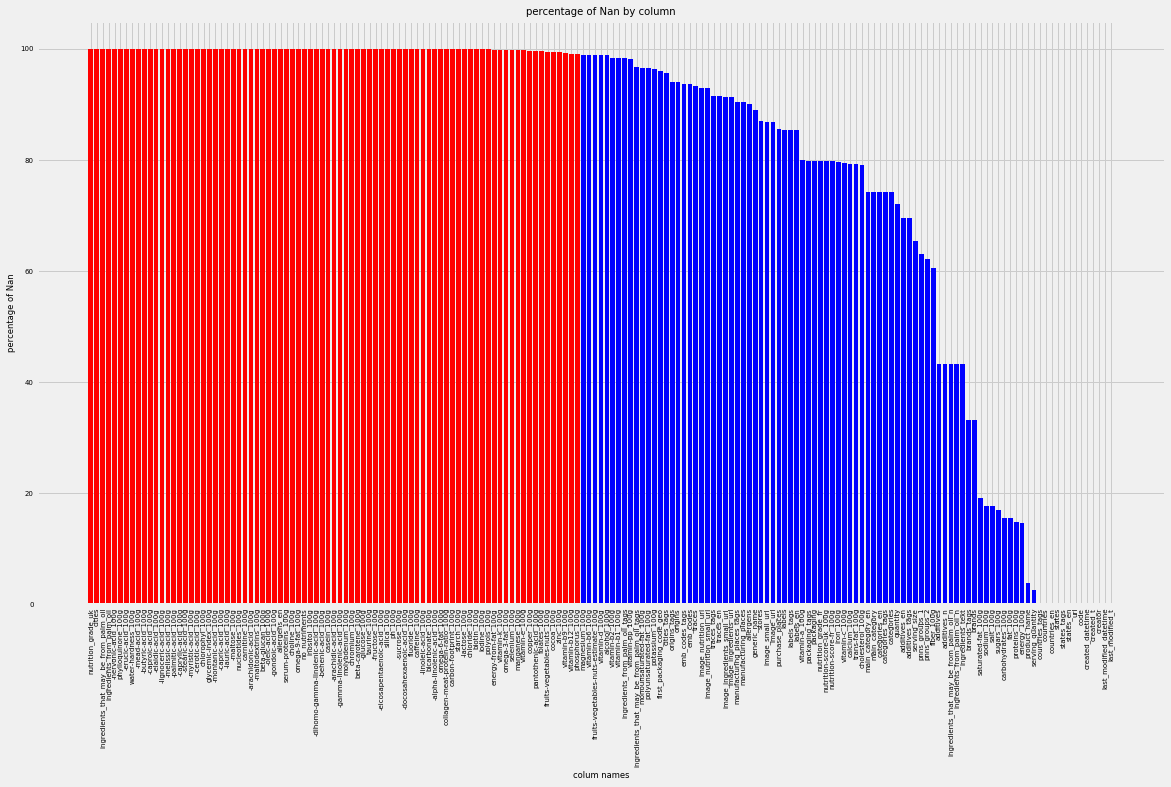

In [8]:
colors = amount_of_nan.apply(lambda percentage: 'b' if percentage < threshold else 'r')
plt.rcParams.update({'font.size': 7})
plt.xticks(rotation='vertical')
plt.bar(amount_of_nan.index, amount_of_nan, color=colors)
plt.title('percentage of Nan by column')
plt.ylabel('percentage of Nan')
plt.xlabel('colum names')

All these columns more than 99% empty (colored in red) will be dropped.

In [9]:
df = df.drop(cols_with_more_than_threshold, axis=1)
df.shape

(692133, 90)

## Dropping uninteresting columns

Open Food Facts offers a large array of columns per product. Some are not interesting considering the subject of our analysis. As such, we will drop the following columns:
* `emb_codes` and `emb_codes_tags` refer to packaging numbers in France.
* `pnns_groups_1` and `pnns_groups_2` only include data in French related to the 'PNNS' dietary guidelines.
* `states`, `states_tags`and `states_en` refer to the state of the entry in the database (tags that still need to be completed).
* `image_url`, `image_small_url`, `image_ingredients_url`, `image_ingredients_small_url`, `image_nutrition_url` and `image_nutrition_small_url` give urls to pictures of the food. We will not use this.


In [10]:
uninteresting_columns_to_drop = ['emb_codes', 'emb_codes_tags', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en', 'image_url',\
                   'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url',\
                   'image_nutrition_url', 'image_nutrition_small_url']

df = df.drop(uninteresting_columns_to_drop, axis = 1)
df.shape

(692133, 77)

## Dealing with date types

The `created_t`, `created_datetime`, `last_modified_t` and `last_modified_datetime` columns deal with dates. We will drop `created_t` and `last_modified_t` as they contain redundant information already in the other two columns.

We will parse the dates in `created_datetime` and `last_modified_datetime` into the datetime type for esier use in our analysis.

In [11]:
df['created_datetime'] = pd.to_datetime(df['created_datetime'], errors = 'coerce', infer_datetime_format = True)
df['last_modified_datetime'] = pd.to_datetime(df['last_modified_datetime'], errors = 'coerce', infer_datetime_format = True)

df = df.drop(['created_t', 'last_modified_t'], axis=1)
df.shape

(692133, 75)

## Removing duplicate columns

Even after all this cleaning, looking at the column names, it seems that a lot of them refer to the same thing. We will check for redundancy among similar column names and drop unnecessary values.

We explore the content of the following groups of columns that seem to have redundant values:
* `categories`, `categories_tags` and `categories_en` are all related to the kind of food the product belongs to.
* `countries`, `countries_tags` and `countries_en` refer to the country of origin.
* `packaging` and `packaging_tags` give info about the type of packaging.
* `brands` and `brands_tags` contain the brand of the product.
* `origins` and `origins_tags`
* `manufacturing_places` and `manufacturing_places_tags`
* `labels`, `labels_tags` and `labels_en`
* `traces`, `traces_tags` and `traces_en`
* `serving_size` and `serving_quantity`
* `additives`, `additives_tags` and `additives_en`
* `main_category` and `main_category_en`

For each of these groups of column we will check that they indeed contain redundant information and remove all columns that are then useless.

In [12]:
# This function will print the ranking of the given columns depending on their proportion of nan values
# It also return a few values where none of the columns are nan to check for redundant data.
def analyze_columns(list_of_columns):
    print(amount_of_nan[list_of_columns].sort_values(ascending = False))
    return df[list_of_columns].dropna().reset_index(drop = 'True').head()

### Category columns

In [13]:
analyze_columns(['categories', 'categories_tags', 'categories_en'])

categories_en      74.241511
categories_tags    74.236599
categories         74.236455
dtype: float64


,categories,categories_tags,categories_en
0,Tartes à la noix de coco,"en:pies,en:sweet-pies,en:coconut-pies","Pies,Sweet pies,Coconut pies"
1,Compotes de poire,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
2,Baguettes,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
3,"Pavés de saumon,Saumons fumés,Pavés de saumon ...","en:seafood,en:fishes,en:salmons,en:smoked-fish...","Seafood,Fishes,Salmons,Smoked fishes,Smoked sa..."
4,Compléments alimentaires,en:dietary-supplements,Dietary supplements


Values among these 3 columns seem largely redundant. We will only keep the `categories_tags` column for its english formatting and convert it to a list of strings for easier analysis later.

In [14]:
redundant_columns_to_drop = ['categories_en', 'categories']
columns_to_convert = ['categories_tags']

### Country columns

In [15]:
analyze_columns(['countries', 'countries_tags', 'countries_en'])

countries_en      0.087266
countries_tags    0.087266
countries         0.087266
dtype: float64


,countries,countries_tags,countries_en
0,en:france,en:france,France
1,en:FR,en:france,France
2,en:france,en:france,France
3,en:france,en:france,France
4,en:france,en:france,France


These columns all cover the same amount of products. We will then only keep `countries_en` for its clearer formatting.

In [16]:
redundant_columns_to_drop += ['countries', 'countries_tags']
columns_to_convert += ['countries_en']

### Packaging columns

In [17]:
analyze_columns(['packaging', 'packaging_tags'])

packaging_tags    79.893460
packaging         79.893026
dtype: float64


,packaging,packaging_tags
0,"barquette,plastique","barquette,plastique"
1,"bocal,plastique","bocal,plastique"
2,plastique,plastique
3,"carton,plastique","carton,plastique"
4,"plastique,carton","plastique,carton"


We keep `packaging` and convert it.

In [18]:
redundant_columns_to_drop += ['packaging_tags']
columns_to_convert += ['packaging']

### Brand columns

In [19]:
analyze_columns(['brands', 'brands_tags'])

brands_tags    33.107799
brands         33.102886
dtype: float64


,brands,brands_tags
0,CROUS,crous
1,"Crous Resto',Crous","crous-resto,crous"
2,Ferme De La Frémondière,ferme-de-la-fremondiere
3,Crous,crous
4,Crous resto,crous-resto


We keep `brands_tags` as it is cleaner than `brands` for a similar number of `nan` values.

In [20]:
redundant_columns_to_drop += ['brands']

### Origin columns

In [21]:
analyze_columns(['origins', 'origins_tags'])

origins_tags    93.971823
origins         93.964021
dtype: float64


,origins,origins_tags
0,France,france
1,Québec,quebec
2,Québec,quebec
3,France,france
4,Québec,quebec


We keep `origins`.

In [22]:
redundant_columns_to_drop += ['origins_tags']

### Manufacturing columns

In [23]:
analyze_columns(['manufacturing_places', 'manufacturing_places_tags'])

manufacturing_places_tags    90.382918
manufacturing_places         90.380028
dtype: float64


,manufacturing_places,manufacturing_places_tags
0,France,france
1,France,france
2,Brossard Québec,brossard-quebec
3,Brossard Québec,brossard-quebec
4,United Kingdom,united-kingdom


We keep only `manufacturing_places`.

In [24]:
redundant_columns_to_drop += ['manufacturing_places_tags']

### Label columns

In [25]:
analyze_columns(['labels', 'labels_tags', 'labels_en'])

labels         85.308893
labels_en      85.304414
labels_tags    85.304414
dtype: float64


,labels,labels_tags,labels_en
0,Fabriqué en France,en:made-in-france,Made in France
1,"Viande Française,Fabriqué en France","fr:viande-francaise,en:made-in-france","fr:Viande Française,Made in France"
2,Contient des OGM,en:contains-gmos,Contains GMOs
3,AB,"en:organic,en:eu-organic,fr:ab-agriculture-bio...","Organic,EU Organic,fr:AB Agriculture Biologique"
4,"Kascher,Contient des OGM","en:kosher,en:contains-gmos","Kosher,Contains GMOs"


`labels_tags` and `labels_en` cover the same rows, we will keep `labels_en` for its formatting and convert it. `labels` is unfortunately in French.

In [26]:
redundant_columns_to_drop += ['labels', 'labels_tags']
columns_to_convert += ['labels_en']

### Traces columns

In [27]:
analyze_columns(['traces', 'traces_tags', 'traces_en'])

traces         93.236271
traces_en      91.468258
traces_tags    91.468258
dtype: float64


,traces,traces_tags,traces_en
0,"milk, egg,","en:eggs,en:milk","Eggs,Milk"
1,"nuts, milk, soya, wheatflour, gluten, oatmeal,...","en:eggs,en:gluten,en:milk,en:nuts,en:soybeans,...","Eggs,Gluten,Milk,Nuts,Soybeans,Oatmeal,Wheatflour"
2,CONTIENT : OEUF. LAIT. ANCHOIS. SOYA. BLE. SEI...,fr:contient-oeuf-lait-anchois-soya-ble-seigle-...,fr:contient-oeuf-lait-anchois-soya-ble-seigle-...
3,"Soja,Anhydride sulfureux et sulfites,Contient ...","en:soybeans,en:sulphur-dioxide-and-sulphites,f...","Soybeans,Sulphur dioxide and sulphites,fr:cont..."
4,"Blé,Orge,Peut contenir: Noix variés Soya Lait...","en:gluten,fr:peut-contenir-noix-varies-soya-la...","Gluten,fr:peut-contenir-noix-varies-soya-lait-..."


`traces_tags` is better formatted and contains less `nan` values.

In [28]:
redundant_columns_to_drop += ['traces', 'traces_en']
columns_to_convert += ['traces_tags']

### Serving size columns

In [29]:
analyze_columns(['serving_size', 'serving_quantity'])

serving_size        65.393790
serving_quantity     2.652091
dtype: float64


,serving_size,serving_quantity
0,28 g (1 ONZ),28
1,28 g (0.25 cup),28
2,28 g (0.25 cup),28
3,35 g (0.25 cup),35
4,52 g (0.5 cup),52


Here, clearly `serving_quantity` is the right choice as it has less `nan` values and is formatted more simply.

In [30]:
redundant_columns_to_drop += ['serving_size']

### Additives columns

In [31]:
analyze_columns(['additives', 'additives_tags', 'additives_en'])

additives_en      69.492569
additives_tags    69.487801
additives         43.253537
dtype: float64


,additives,additives_tags,additives_en
0,[ antioxydant -> fr:antioxydant ] [ erythor...,"en:e150,en:e160a,en:e202,en:e316,en:e466","E150 - Caramel,E160a - Alpha-carotene,E202 - P..."
1,[ lait-entier -> fr:lait-entier ] [ lait ->...,en:e406,E406 - Agar
2,[ paln-suedois-42 -> fr:paln-suedois-42 ] [...,"en:e300,en:e503","E300 - Ascorbic acid,E503 - Ammonium carbonates"
3,[ taboule-76 -> fr:taboule-76 ] [ taboule -...,en:e202,E202 - Potassium sorbate
4,[ pain-aux-6-cereqles-61 -> fr:pain-aux-6-cer...,"en:e250,en:e252","E250 - Sodium nitrite,E252 - Potassium nitrate"


Looking at the proportion of `nan` values, the `additives` column seems to be the best choice. However, its content is not what we expected. We will instead keep `additives_tags`.

In [32]:
redundant_columns_to_drop += ['additives', 'additives_en']
columns_to_convert += ['additives_tags']

### Main category columns

In [33]:
analyze_columns(['main_category', 'main_category_en'])

main_category_en    74.252203
main_category       74.252203
dtype: float64


,main_category,main_category_en
0,en:pies,Pies
1,en:plant-based-foods-and-beverages,Plant-based foods and beverages
2,en:plant-based-foods-and-beverages,Plant-based foods and beverages
3,en:seafood,Seafood
4,en:dietary-supplements,Dietary supplements


Their percentage of `nan` values are identical, we keep `main_category_en`.

In [34]:
redundant_columns_to_drop += ['main_category']

### Dropping columns and performing conversions

Finally, we remove all the columns from the dataframe and we convert several columns from strings to list of strings.

In [35]:
print(redundant_columns_to_drop)
print(columns_to_convert)

['categories_en', 'categories', 'countries', 'countries_tags', 'packaging_tags', 'brands', 'origins_tags', 'manufacturing_places_tags', 'labels', 'labels_tags', 'traces', 'traces_en', 'serving_size', 'additives', 'additives_en', 'main_category']
['categories_tags', 'countries_en', 'packaging', 'labels_en', 'traces_tags', 'additives_tags']


In [36]:
df = df.drop(redundant_columns_to_drop, axis = 1)
df.shape

(692133, 59)

In [37]:
for col in columns_to_convert:
    df[col] = df[col].astype(str).apply(lambda s: s if s == 'nan' else s.split(','))
    
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692133 entries, 0 to 692132
Data columns (total 59 columns):
code                                          692099 non-null object
url                                           692099 non-null object
creator                                       692130 non-null object
created_datetime                              692098 non-null datetime64[ns]
last_modified_datetime                        692099 non-null datetime64[ns]
product_name                                  665819 non-null object
generic_name                                  76748 non-null object
quantity                                      192720 non-null object
packaging                                     692133 non-null object
brands_tags                                   462983 non-null object
categories_tags                               692133 non-null object
origins                                       41777 non-null object
manufacturing_places                          6

### Removing illogical entries

Even after having cleaned all this we should be careful to remove any illogical entries. Indeed, some values are obvious wrong entries.

First, we consider values of the form `carbohydrates_100g` (this indicates the amount of carbohydrates per 100g). This value must necessarely be between 0 and 100. We remove all entries not in this range.

In [38]:
per_100g_columns = ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g',\
                    'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',\
                    'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',\
                    'salt_100g', 'sodium_100g']

for col in per_100g_columns:
    df = df[((0 <= df[col]) & (df[col] <= 100)) | df[col].isna()]

The `energy_100g` column indicates the amount of energy per 100g in kJ. Fat provides the most energy per gram with 37.7kJ in a gram of fat [\[source\]](http://www.nutritionaustralia.org/national/resource/balancing-energy-and-out). As such, a product containing only fat would provide 100 * 37.7 = 3770kJ of energy. We remove any entry with a value higher than this.

In [39]:
df = df[((0 <= df['energy_100g']) & (df['energy_100g'] <= 3770)) | df['energy_100g'].isna()]

Sugars are actually a subset of carbohydrates. This means that we cannot have more sugars per 100g than carbohydrates. Similarly, saturated fats are a subset of fat.

We remove entries where the subset has a higher content than its category.

In [40]:
df = df[df['sugars_100g'] <= df['carbohydrates_100g']]
df = df[df['saturated-fat_100g'] <= df['fat_100g']]

# 2. Looking at the cleaned data

## For which countries do we have data?

Our analysis had the aim of covering the whole world as Open Food Facts is not limited to any country. It is important that we check if this is possible by looking at how much data is availble in every country and if we have enough to do a world analysis (we'll see that this is not the case and we will have to pivot our analysis).

We first define a function so that we can analyze different metrics aggregated per country.

In [41]:
# metric is a function row -> value. It might be any measurement we want to do (amount of fat, ...)
# aggrate_function if a function list(value) -> score (median, sum, ...) leading to the final score for one country
# we do not keep the values if the list has less than n_mini items, to deal with countries with not enough data
def group_by_country_and_aggregate(df, metric, metric_name, aggregate_function, n_mini):
    
    # fill a dictionnary {country: [metric_product1, metric_product2, metric_product3, ...]}
    per_country = {}

    # helper function:
    # for each country mentionned in row, add the value (using the metric) to the list of values for this country
    def add_value(row):
        
        # if the metric cannot be computed, return
        val = metric(row)
        
        try:
            if pd.isnull(val):
                return
        except:
            if not val:
                return
        
        for country in row["countries_en"]:
            if not country in per_country.keys():
                per_country[country] = []
            per_country[country] += [val]

    # calls the helper for all the rows
    for _, row in df.iterrows():
        add_value(row)
    
    # filter the lists that have les than n_mini elements
    filtred_dict = {}
    for k in per_country.keys():
        l = per_country[k]
        if len(l) >= n_mini:
            filtred_dict[k] = l
    
    # get the list of countries
    countries = list(filtred_dict.keys())
    
    # call our aggregation function for each list of more than n_mini elements 
    final_scores =  [aggregate_function(filtred_dict[c]) for c in countries]

    # finally, build a DF with the result and return it
    return pd.DataFrame({"country": countries, metric_name: final_scores}).set_index("country").sort_values(metric_name, ascending=False)

Since we want to analyze the quality of foods in the world, it is crucial that we understand which countries have the most entries.

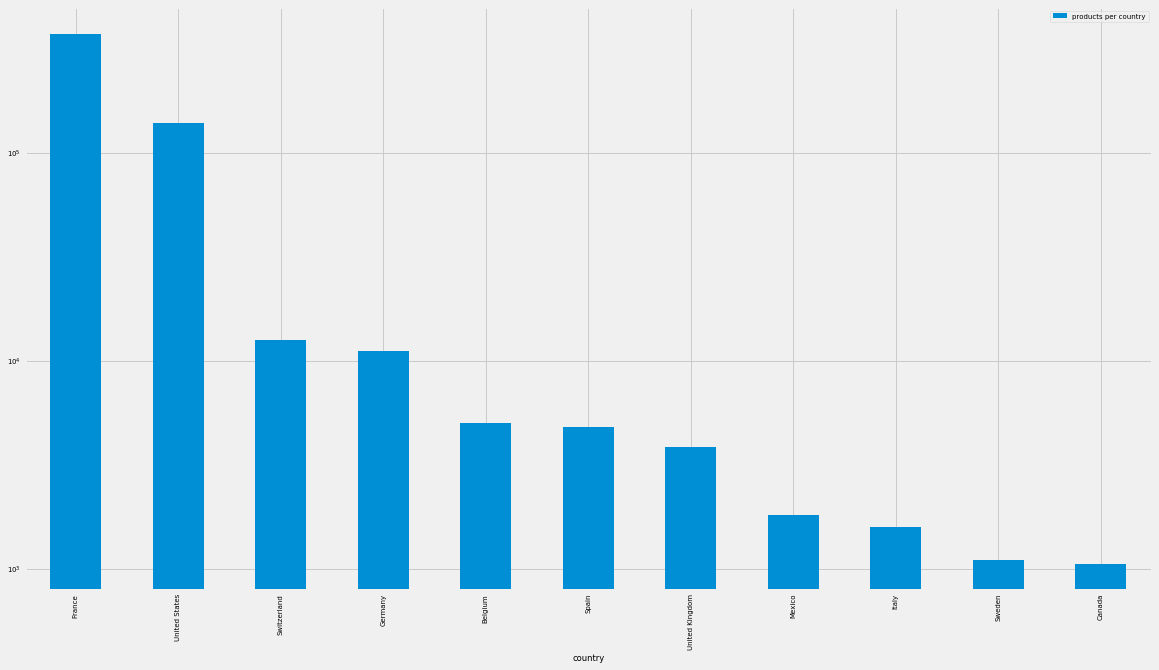

In [42]:
entries_per_country = group_by_country_and_aggregate(df, lambda x: 1, "products per country", np.sum, 1000)
entries_per_country.plot.bar(logy=True)

The top 3 countries for which we have data are France, the US and Switzerland. Germany, Belgium, Spain and the UK have a lot of data points also but for other countries we have much fewer information.

In particular, we don't have as many values as we expected for other areas in the world (Asia and Africa is especially absent). We might have to shift our analysis from the whole world to the set of countries for which we have data (North Amercia and Western Europe).

It could be interesting to look at who are the most important contributors to the database also as this might explain the differences in quantity of data per country.

Text(0,0.5,'number of contributions')

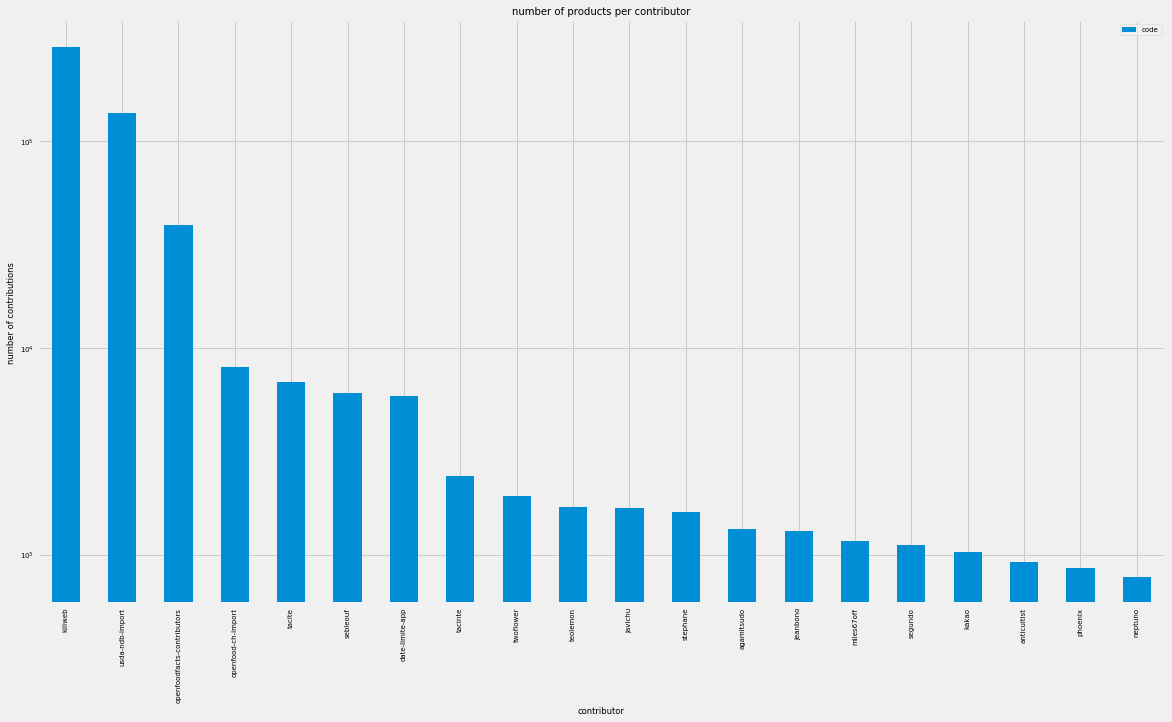

In [43]:
# we do not need the whole dataframe for this
mini_df = df[['creator','code']]
mini_df.groupby('creator').count().sort_values('code', ascending=False).head(20).plot.bar(logy=True)
plt.title('number of products per contributor')
plt.xlabel('contributor')
plt.ylabel('number of contributions')

Indeed it is very interesting to look at the contributors!

We find explanations for the top 3 countries:
* France: Open Food Facts started as a French project (which explains why we saw so many values in French during the cleaning part). On top of this, kiliweb is the most important contributor to the data. They are a [french web design and app developper](https://kiliweb.fr/), most notably for us they developped [Yuka](https://itunes.apple.com/fr/app/yuka-analyse-de-produits-alimentaires/id1092799236?mt=8) which is currently the number 1 health app on the French app store and allows for scanning of food product bar codes (it's basically a pretty front-end for Open Food Facts).
* USA: The US department of agriculture gathers a lot of data on food products sold in the United States. They have transferred a lot of this data over to Open Food Facts.
* Switzerland: Yuka is also the number one health app on the Swiss app store (so some of the kiliweb entries also transfer to Switzerland) and very interestingly the fourth biggest contributor is [openfood.ch](https://www.foodrepo.org/) (now renamed foodrepo.org) that is an Open Food Facts cloned focused on Switzerland that was actually [launched by EPFL last year](https://actu.epfl.ch/news/food-data-at-your-fingertips-4/)! They must have included their data to Open Food Facts.

To get an even better idea of which regions are interesting for our analysis we visualize which countries have more than 1000 entries.

In [44]:
entries_per_country_dict = entries_per_country.to_dict()['products per country']
entries_per_country = entries_per_country.reset_index()

# here we add 0 values to all countries which have less than a 1000 entries and
# 1 to countries with more than a 1000 entries
# this section is needed because by default choropleth displays missing values as max value
world_map = './data/world-countries.json'
countries = []
entries_count = []
json_object = json.load(open(world_map))

# we iterate over all countries in our world geo json
for country in json_object['features']:
    country_name = country['properties']['name']
    countries.append(country_name)
    if country_name in list(entries_per_country_dict.keys()):
        entries_count.append(1)
    else:
        entries_count.append(0)

# we recreate a dataframe with all countries
full_entries_per_country_dict = pd.DataFrame({"country": countries, 'products per country': entries_count})

map = folium.Map(location=[20, 0], zoom_start=2)
map.choropleth(geo_data=world_map, data=full_entries_per_country_dict,
             columns=['country', 'products per country'],
             key_on='feature.properties.name',
             fill_color='YlGn')
map.save('map.html')
map

The map is available [here](map.html) for viewing on github.

Clearly only North America and Europe are valid for our analysis.

We will definitely update our README to shift our analysis to North America and Western Europe.

## Is the data current?

Open Food Facts was [launched in 2012](https://en.wikipedia.org/wiki/Open_Food_Facts). We would like to check whether the data on the wesite is still current as we wish to analyze foods that are available right now.

Let's see how many new entries are added per year on the website.

Text(0,0.5,'number of new entries')

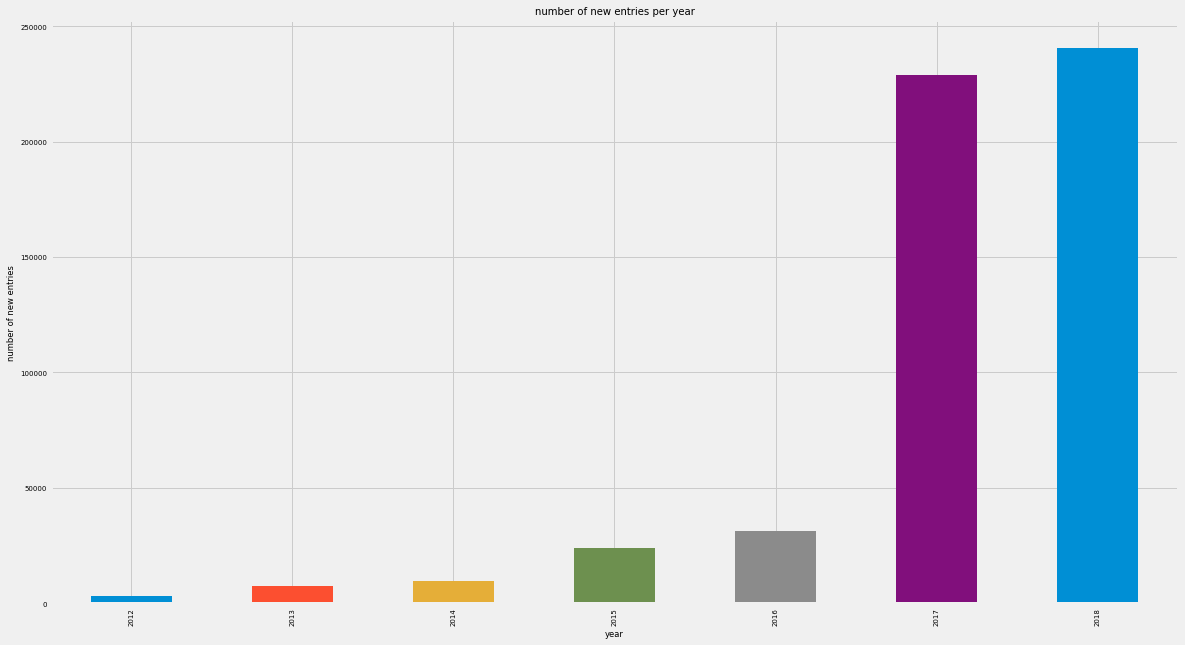

In [45]:
df['created_datetime'].dropna().map(lambda x: int(x.year)).value_counts().sort_index().plot.bar()
plt.title('number of new entries per year')
plt.xlabel('year')
plt.ylabel('number of new entries')

This is good news for our analysis! More and more data is added each year so we should not have to worry about only dealing with older products that might not even be available anymore. This is really not a concern when we see that alsmost all entries are actually from the last two years.

On top of this, we can also check whether or not the data has been updated.

Text(0,0.5,'number of modified entries')

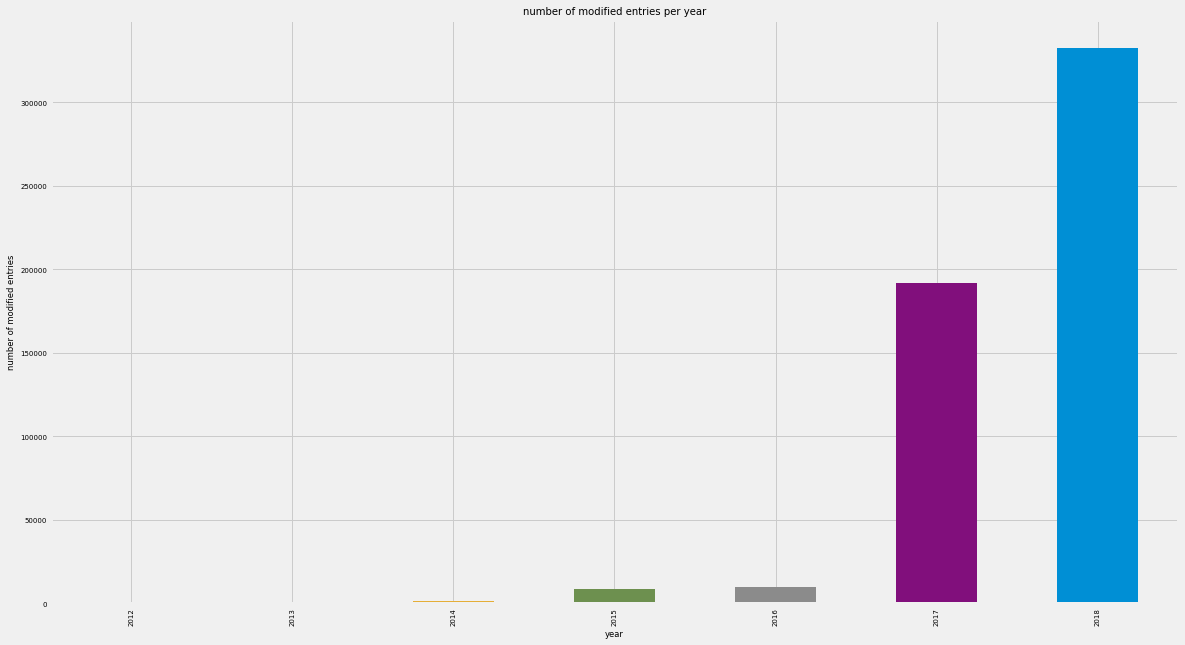

In [46]:
df['last_modified_datetime'].map(lambda x: x.year).value_counts().sort_index().plot.bar()
plt.title('number of modified entries per year')
plt.xlabel('year')
plt.ylabel('number of modified entries')

We really don't have to worry about outdated data. Indeed, most updates were done this year.

## A first look at the data points most interesting for our questions

Let's now see if we can get basic insights on the colummns most interesting for the questions we want to consider.

### Numerical values

Let's see if our numerical values have any important correlations so that we can better understand what is inside our data (and our food).

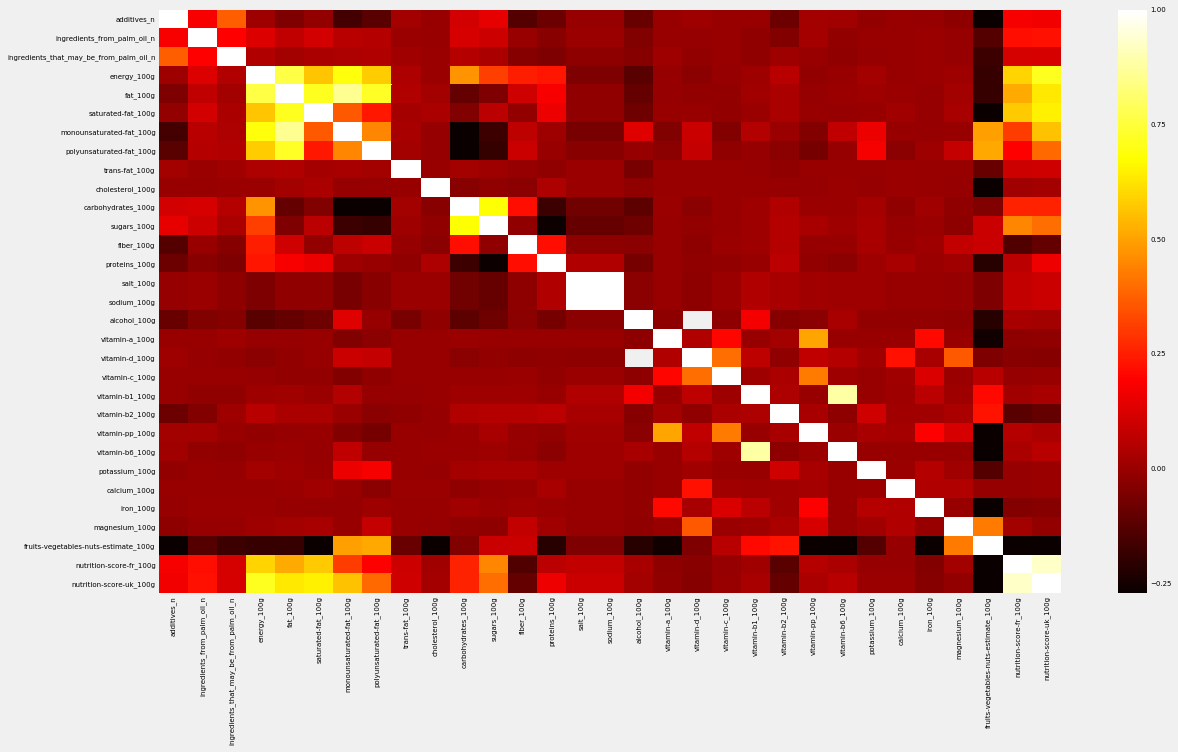

In [47]:
numeric_df = df.select_dtypes(include = 'float64')
sns.heatmap(numeric_df.corr(), cmap ='hot', robust = True)

Most of our values are poorly correlated.

Most of the fats (total trans, saturated, unsaturated), as well as the energy, are correlated, which is normal.

Some of the vitamins are correlated together, mostly A <-> D and C <-> D. This correlation does not seem correct, since D vitamine is found mostly in fishes or animal products, whereas A and C vitamin is found mostly in vegetables.

The general conclusion we can draw is that the values are not or poorly correlated, and that this simple heatmap is not sufficient to understand the correlations. We checked the relevence of some of the correlations on the web: it seems that the majority of the correlations are not real, but due to the fact that some columns contains almost only zeroes in the dataframe.

### Palm oil

Palm Oil is an oil extracted from the fruit of the trees called African Oil Palms. It is used in food products, soap and biodiesel. Palm Oil's high consumption and production has been at
					the center of multiple <a href="https://www.bbc.co.uk/newsround/39492207">controversies</a> in Europe. We will study the extent of Palm Oil use is food products in European and North American countries and will try to understand where Palm
					Oil's bad reputation comes from.
## What is Palm Oil? How common is it in European foods? Is it bad for your health?

In [48]:
def percentage_of_palm_based_products(column_name, threshold):
    df_by_brands = df[[column_name,'ingredients_from_palm_oil_n']]
    df_by_brands = df_by_brands.dropna()
    df_by_brands.ingredients_from_palm_oil_n = df_by_brands.ingredients_from_palm_oil_n
    df_by_brands = df_by_brands.groupby([column_name])

    values_dict = {column_name: [], 'percentages_of_palm_based_products':[]}
    for name, group_ingredients_palm in df_by_brands:
        number_of_products = len(group_ingredients_palm)
        if number_of_products > threshold:
            n_products_containing_palm = group_ingredients_palm['ingredients_from_palm_oil_n'].astype(bool).sum()
            percentage = n_products_containing_palm / number_of_products
            if percentage > 0.02:
                values_dict['percentages_of_palm_based_products'].append(percentage)
                values_dict[column_name].append(name)
    return pd.DataFrame.from_dict(values_dict).set_index(column_name)

In [55]:
number_of_products_with_palm_oil_data = len(df.ingredients_from_palm_oil_n.dropna())
number_of_products_with_palm_oil_based_ingredients = df.ingredients_from_palm_oil_n.dropna().astype(bool).sum()
percentage_of_products_containing_palm_oil = 100 * number_of_products_with_palm_oil_based_ingredients / number_of_products_with_palm_oil_data

print('percentage of products containing palm oil:', round(percentage_of_products_containing_palm_oil,2), '%')

percentage of products containing palm oil: 3.43 %


['d' 'a' 'e' 'b' 'c']


/home/kyle/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


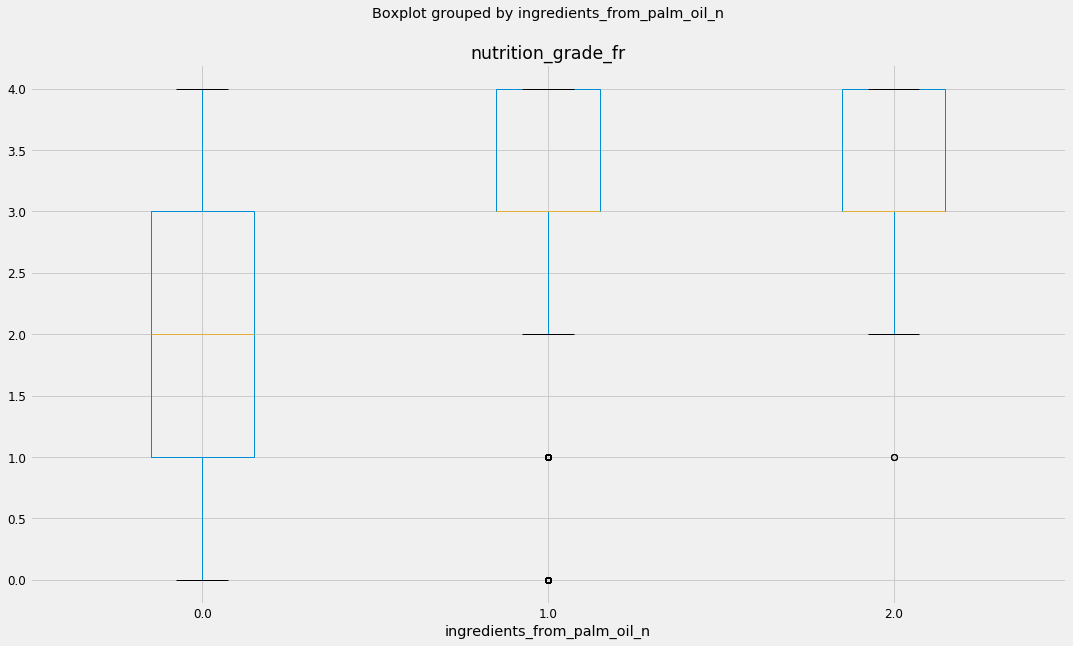

In [56]:
def grade_to_score(x):
    return ord(x) - ord('a')

nutrition_grade_fr_df = df.dropna(subset=['nutrition_grade_fr'])
print(nutrition_grade_fr_df.nutrition_grade_fr.unique())
nutrition_grade_fr_df.nutrition_grade_fr = nutrition_grade_fr_df.nutrition_grade_fr.apply(grade_to_score)
nutrition_grade_fr_df.boxplot(column='nutrition_grade_fr', by='ingredients_from_palm_oil_n')
plt.savefig('nutrition_grade_palm_oil.png', transparent=True)

Let's see what brands in the dataset use palm oil the most.

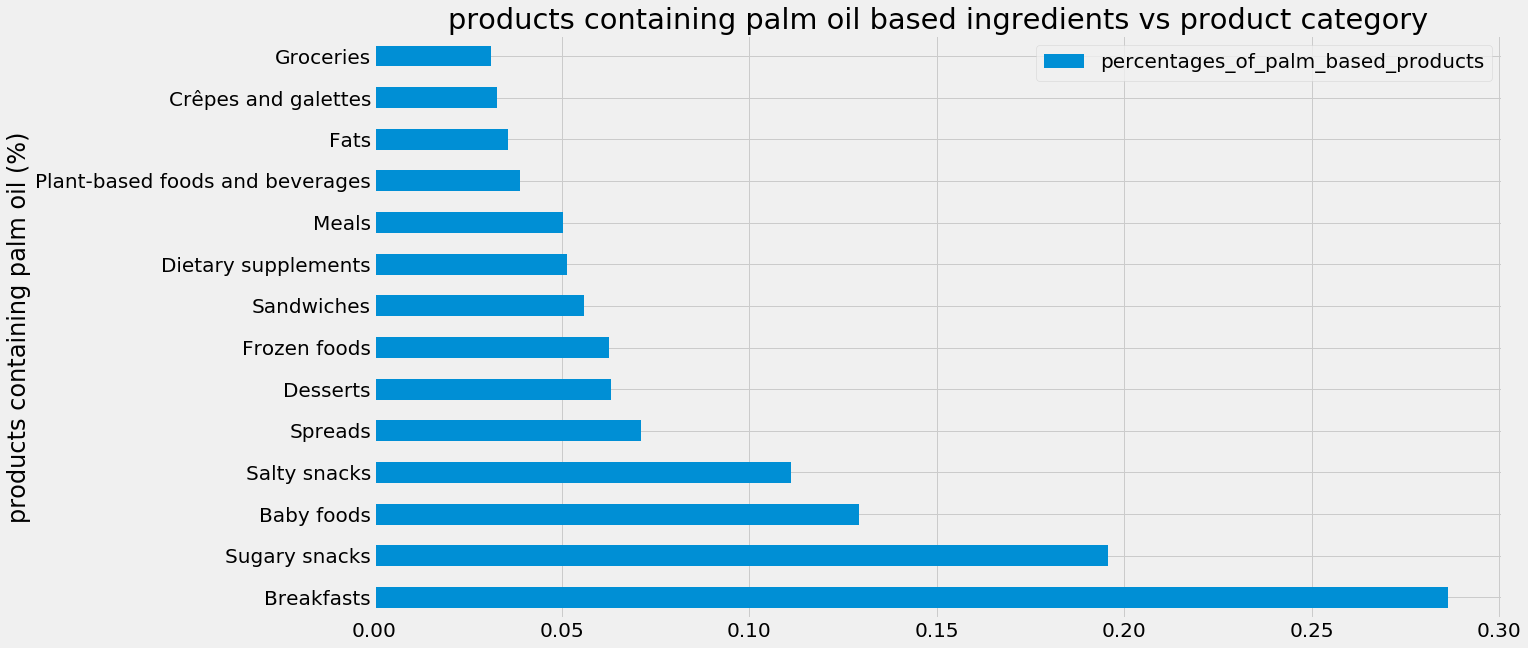

In [81]:
plt.rcParams.update({'font.size': 20})
palm_broducs_by_brand = percentage_of_palm_based_products('main_category_en', 200)
palm_broducs_by_brand.sort_values(by='percentages_of_palm_based_products', ascending=False).plot.barh()
plt.ylabel('products containing palm oil (%)')
plt.title('products containing palm oil based ingredients vs product category')
plt.savefig('images/palm_oil_per_category.png', transparent=True, bbox_inches='tight', dpi = 300)

Breakfast is the category with the highest palm oil percentage, this makes sense when we consider things like spreads (which unfortunately also have their own category, this is proaly a slight categorization problem). It's not surprising to see that snacks (whether sugary or salty )

Data concerning palm oil seems to make sense here. This is something we can pursue in our analysis.

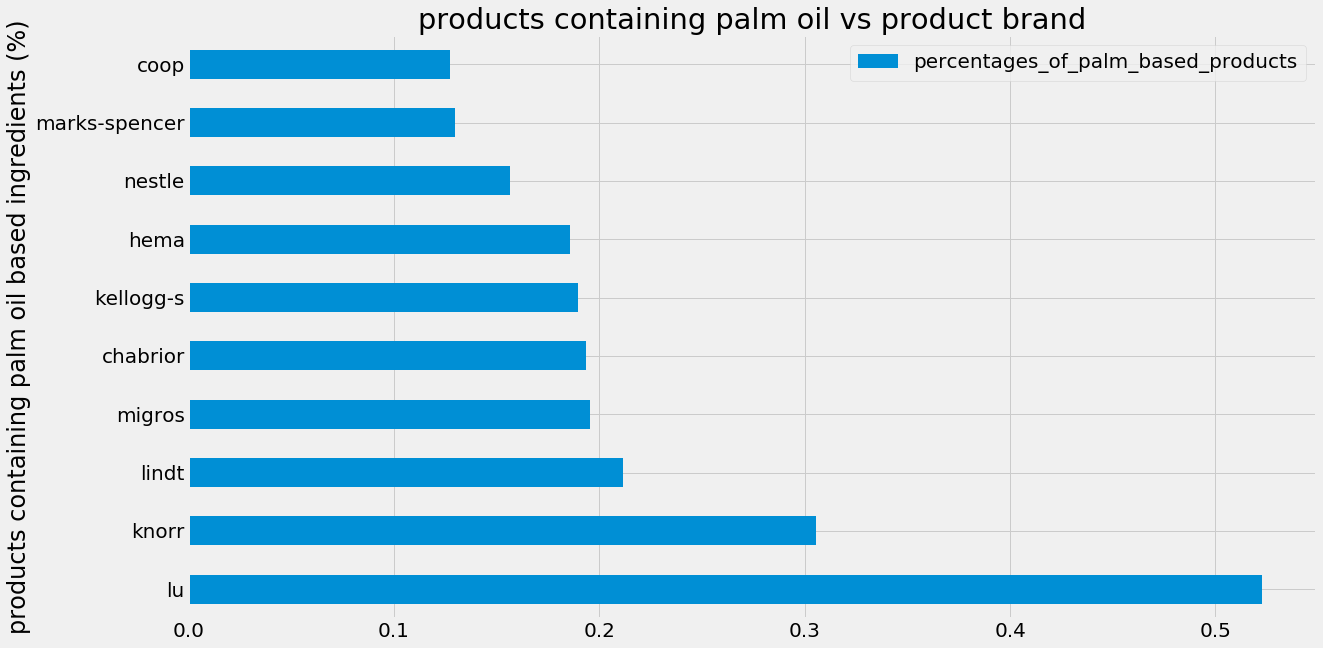

In [80]:
palm_broducs_by_brand = percentage_of_palm_based_products('brands_tags', 300)
palm_broducs_by_brand.sort_values(by='percentages_of_palm_based_products', ascending=False)[:10].plot.barh()
plt.ylabel('products containing palm oil based ingredients (%)')
plt.title('products containing palm oil vs product brand')
plt.savefig('images/palm_oil_per_brand.png', transparent=True, bbox_inches='tight', dpi = 300)

The top 3 values are Lu, Knorr and Migros. This makes sense as the first brand is a mass producer of cakes and biscuits (both of which often contain inexpensive vegetable oils such as palm oil). Same for Knorr and Migros, they offer a large selection of prepared foods that make us of palm oil to cut down on costs.

## Why does palm oil have a bad reputation?
### Where is it produced?  Economic situation of countries / regions where it is produced

In [65]:
gdp_per_country_path = data_path + 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv'
gdp_per_country = pd.read_csv(gdp_per_country_path, low_memory = False, encoding='utf-8').dropna().reset_index()

palm_oil_path = data_path + 'Palm_oil_mills.csv'
palm_mills = pd.read_csv(palm_oil_path, low_memory = False, encoding='utf-8').dropna().reset_index()

In [66]:
world_map = './data/world-countries.json'
json_object = json.load(open(world_map))
countries = []
all_valid_countries = []
gdps = []

for country in json_object['features']:
    country_name = country['properties']['name']
    all_valid_countries.append(country_name)
    if country_name not in gdp_per_country['Country Name'].unique():
        gdps.append(0)
        countries.append(country_name)

gdp_per_country = gdp_per_country.loc[gdp_per_country['2017'] < 85000]
df2 = pd.DataFrame({"Country Name": countries, '2017': gdps}).reset_index()

map = folium.Map(location=[20, 0], zoom_start=2)
map.choropleth(geo_data=world_map, data=gdp_per_country.append(df2),
             columns=['Country Name', '2017'],
             key_on='feature.properties.name',
             fill_color='BuGn')

tooltip = 'Palm oil Mill name'

for index, row in palm_mills.iterrows():
    folium.CircleMarker(
    location=[row['latitude'], row['longitude']],
    radius=1,
    popup=row['mill_name_'],
    color='red',
    fill=True,
    fill_color='#3186cc'
    ).add_to(map)
map.save('map.html')
map

In [71]:
import matplotlib.path as mplPath
import json
from os import listdir
from os.path import isfile, join

directory = './data/countries/'
onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]

country_dict = {}
for file in onlyfiles:
    with open(directory + '/' + file) as f:
        data = json.load(f)
        country_name = data['features'][0]['properties']['name']
        pos = (96.25,-75)
        polygons = data['features'][0]['geometry']['coordinates']
        type_polygon = data['features'][0]['geometry']['type']
        inside_polygon = False
        country_dict[country_name] = []
        if type_polygon == 'Polygon':
            polygon = polygons[0]
            bbPath = mplPath.Path(polygon)
            country_dict[country_name].append(bbPath)
        else:
            for poly in polygons:
                poly = poly[0]
                bbPath = mplPath.Path(poly)
                country_dict[country_name].append(bbPath)
                
def convert(lat, lon, country_dict):
    for country_name, polygons in country_dict.items():
        for polygon in polygons:
            inside_polygon = polygon.contains_point((lon,lat))
            if inside_polygon:
                return country_name
    return 'Unknown'

palm_mills['country'] = palm_mills.apply(lambda row: convert(-row.latitude, row.longitude, country_dict), axis=1)
counts_per_country = palm_mills['country'].value_counts()
counts_per_country

Unknown             511
Indonesia           357
Malaysia             44
Peru                 15
Brazil                2
Colombia              2
Papua New Guinea      1
Chile                 1
Name: country, dtype: int64

In [79]:
def filter_(country_name):
    return gdp_per_country[gdp_per_country['Country Name'] == country_name]

Indonesia_gdp = filter_('Indonesia').iloc[0]['2017']
Swiss_gdp = filter_('Switzerland').iloc[0]['2017']
print('Indonesia GDP per capita:', Indonesia_gdp)
print('Swiss GDP per capita:', Swiss_gdp)
print('Indonesia GDP per capita is', int(Swiss_gdp/Indonesia_gdp), "times smaller than Switzerland's")

Indonesia GDP per capita: 3846.8643233099797
Swiss GDP per capita: 80189.6968607849
Indonesia GDP per capita is 20 times smaller than Switzerland's


## Sugar and Fat

Similarly to palm oil, a lot of our questions were related to sugar and fat. We will try and get basic insights as a sanity check to make sure we can follow through with this in the future. Let's start by looking at the median sugar content of products by country.

In [70]:
mean_sugar_per_country = group_by_country_and_aggregate(df,\
    lambda r: r["sugars_100g"], "median sugar per 100g", np.median, 1000)

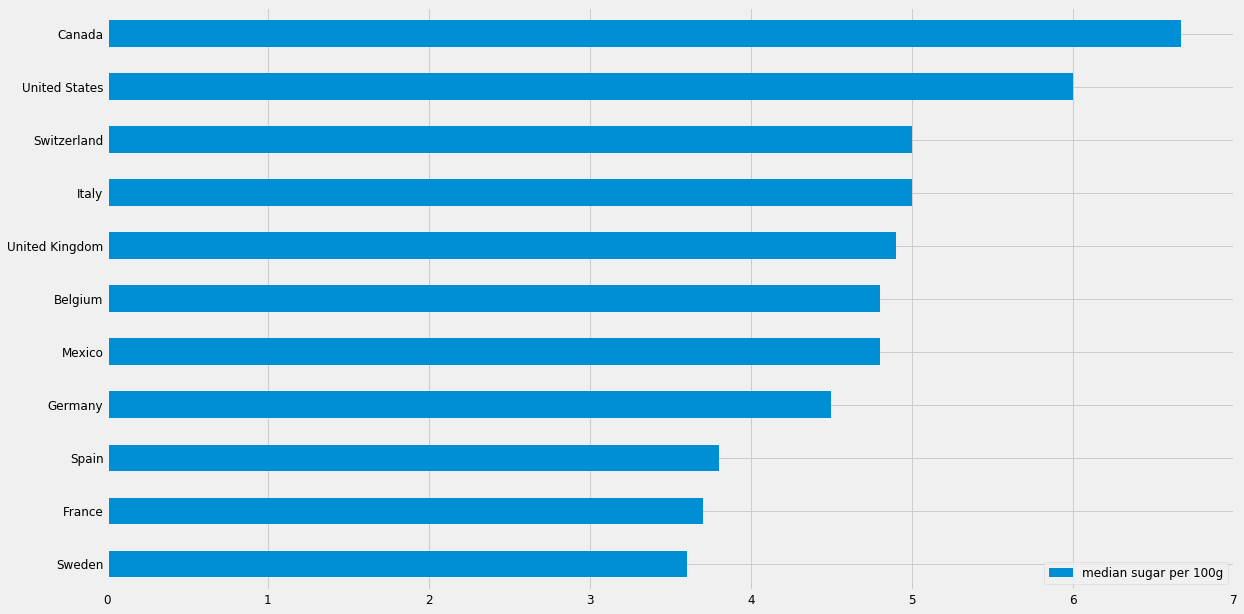

In [52]:

# this reindex operation reverts the serie
mean_sugar_per_country.reindex(index=mean_sugar_per_country.index[::-1]).plot.barh()
plt.ylabel("")
plt.savefig('images/median_sugar_per_country.png', transparent=True, bbox_inches='tight', dpi = 300)

In [53]:
print(plt.style.available)

['fivethirtyeight', 'dark_background', 'Solarize_Light2', 'bmh', 'tableau-colorblind10', '_classic_test', 'seaborn', 'seaborn-colorblind', 'seaborn-ticks', 'seaborn-darkgrid', 'classic', 'seaborn-white', 'grayscale', 'ggplot', 'seaborn-talk', 'seaborn-muted', 'fast', 'seaborn-pastel', 'seaborn-poster', 'seaborn-notebook', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-deep', 'seaborn-paper', 'seaborn-whitegrid', 'seaborn-bright']


Our top three is then:
* Canada
* The US
* Switzerland

Now that we have an overview of the countries offering a lot sugar, we want to specify by category. We find the categories with the most median sugar content.

In [1]:
def q10(l):
    return np.quantile(l,0.25)
def q90(l):
    return np.quantile(l,0.75)

def err(bar):
    return np.array([bar["median"] - bar["q10"], bar["q90"] - bar["median"]])



test_sugar = df.groupby("main_category_en")["sugars_100g"].aggregate(["median", "count", q10, q90])
bar = test_sugar[test_sugar["count"] > 1000].sort_values(by="median", ascending=True)

plt.title("Sugar rate of 80% of the food, by category")
bar["median"].plot.barh(xerr=err(bar))
plt.ylabel("")
plt.savefig('images/median_sugar_per_category.png', transparent=True, bbox_inches='tight', dpi = 300)


NameError: name 'df' is not defined

The three food categories with the most sugar are:
1. Sugary Snacks
2. Desserts
3. Fruit juices

Let's focus on the sugary snacks and compare countries with the top three highest median sugar content. We'll separate Switzerland and North America (USA + Canada).

In [ ]:
north_america_mask = df.apply(lambda r: "United States" in r["countries_en"] or "Canada" in r["countries_en"], axis=1)
north_america = df[north_america_mask]

switzerland_mask = df.apply(lambda r: "Switzerland" in r["countries_en"], axis=1)
switzerland = df[switzerland_mask]

Let's compare the two regions by median sugar content on a few product categories.

In [ ]:
compared_categories =  {"Sugary snacks", "Fruit juices", "Beverages", "Groceries"}

sugar_switzerland = switzerland.groupby("main_category_en")["sugars_100g"].aggregate(["median", "count", q10, q90])
sugar_switzerland = sugar_switzerland.sort_values(by="count", ascending=False)

selected_categories = sugar_switzerland.index.map(lambda r: r in compared_categories)
median_sugar_switzerland = sugar_switzerland[selected_categories].sort_index(ascending=False)

sugar_north_america = north_america.groupby("main_category_en")["sugars_100g"].aggregate(["median", "count", q10, q90])
sugar_north_america = sugar_north_america.sort_values(by="count", ascending=False)

selected_categories = sugar_north_america.index.map(lambda r: r in compared_categories)
median_sugar_north_america = sugar_north_america[selected_categories].sort_index(ascending=False)
median_sugar_switzerland

In [ ]:
fig, ax = plt.subplots()

ind = np.arange(4)    # the x locations for the groups
width = 0.35         # the width of the bars


p1 = ax.bar(ind, median_sugar_switzerland["median"], width, bottom=0)#, yerr=err(median_sugar_switzerland))
p2 = ax.bar(ind + width, median_sugar_north_america["median"], width, bottom=0)

ax.set_title('Sugar per category: Switzerland - North America')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_sugar_switzerland.index)

ax.legend((p1[0], p2[0]), ('Switzerland', 'North America'))
ax.autoscale_view()

plt.savefig('images/america_swiss_sugar_caomparaison.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

Surprisingly, Switzerland's sugary snacks have a much higher median sugar content than those sold in North America!

To investigate this trend, let's consider the brands selling the most sugary foods.

In [ ]:
test_sugar = df.groupby("brands_tags")["sugars_100g"].aggregate(["median", "count"])
test_sugar[test_sugar["count"] > 1000].sort_values(by="median", ascending=True)["median"].plot.barh()
plt.ylabel("")
plt.savefig('images/top_sugar_brands.png', transparent=True, bbox_inches='tight', dpi = 300)

Nestlé comes in first with a median sugar content four times superior to Spartan in second place!

Let's take a look at the words most present in the Nestlé sugary snacks.

In [ ]:
def plot(word_list, figsize=(10, 10), **kwargs):
    wlist = word_list.copy()
    
    # shuffle the list to avoid patterns
    np.random.shuffle(wlist)    
    words = ""
    for word in wlist:
        words += word
        words += " " 
    wordcloud = WordCloud(**kwargs).generate(words)
    print(wordcloud)
    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

In [ ]:
def stringify(df):
    l = []
    for name in df["product_name"]:
        for n in str(name).split():  
            if (len(n) > 2 and n != "aux"):
                l += [n]
    return l

In [ ]:
sugary_snacks_df = df[df["main_category_en"] == "Sugary snacks"]
nestle_snacks = sugary_snacks_df[sugary_snacks_df["brands_tags"] == "nestle"]

plot(stringify(nestle_snacks), figsize=(10, 10), width = 1920, height = 1080, min_font_size=8, )

A clear pattern emerges and we see that chocolate stands out and appears a lot in sugary snack product names. This could actually explain the importance of Switzerland in data.

In [ ]:
plot(stringify(switzerland[switzerland["main_category_en"] == "Sugary snacks"]), figsize=(10, 10), width = 1920, height = 1080, min_font_size=8)

# Additives

In [ ]:
def additives(row):
    return row["additives_tags"]

def n_distinct_additives(additives_list):
    total_list = set()
    for  additives in additives_list:
        for a in additives:
            total_list.add(a)
    return len(total_list)

number_additives_per_country = group_by_country_and_aggregate(df, additives, "number of different additives", n_distinct_additives, 1000)
number_additives_per_country.plot.bar()

We find that the countries with the greatest variety of additives on open food facts are:
1. France
2. USA
3. Switzerland

This makes sense considering that these are the countries with the greatest quantity of entries on the website. It would be interesting however to compare this variety of additives to the proportion of those considered dangerous. Do the same countries show up at the top if we consider the proportion of dangerous additives?

In [ ]:
def rate_of_additives_in(additives_list, additives_set):   
    l = 0     
    for additives in additives_list:
        for a in additives:
            if a in ["n", "a"]:
                break
            if a[3:].lower() in additives_set:           
                l += 1
    return l / len(additives_list)

In [ ]:
def rate_of_dangerous_additives(additives_list):
    # source: https://www.foodmatters.com/article/top-10-food-additives-to-avoid
    dangerous_additives = ["e951", "e621", "e133", "e124", "e110", "e102", "e221", "e320", "e220"]
    return rate_of_additives_in(additives_list, dangerous_additives)
 
name = "at least one unpopular additive"
danger_additives_per_country = group_by_country_and_aggregate(df, additives, name, rate_of_dangerous_additives, 1000)
danger_additives_per_country.sort_values(name, ascending=False).plot.bar()

Interestingly, only the US is also in the top of countries with a proportion of dangerous additives. France, while it was the country with the largest variety of additives, does not have a very high proportion of dangerous additives.

How do France and the US differ in terms of additives legislation? We first try to get an idea by looking at additives present in US foods but not available in France.

In [ ]:
def distinct_additives(additives_list):
    total_list = set()
    for  additives in additives_list:
        for a in additives:
            a = str(a)
            if a != "n" and a != "a":          
                total_list.add(a[3:])
    return total_list

additives_df = group_by_country_and_aggregate(df, additives, "additives", distinct_additives, 100)

In [ ]:
set_us_additives = additives_df[additives_df.index == "United States"]["additives"].iloc[0]
set_fr_additives = additives_df[additives_df.index == "France"]["additives"].iloc[0]

set_us_additives - set_fr_additives

Actually forbidden in France:
* E105
* E107
* E908
* E924a
* E927a, it is also forbidden in the whole EU but was used by Subway and Wendy's [in the US](https://en.wikipedia.org/wiki/Azodicarbonamide#Safety_and_regulation).
* E928, it is also forbidden in the rest of the EU, Australia and New Zealand.
* E409, it is also forbidden in the EU.
* E488
* E539, it is also forbidden in the EU.

Not present yet allowed in French products:
* E161G [since 1997](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)is actually only allowed in "Saucisse de Strabourg" which explains its abscence in the dataset.
* E343i [since 2007](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E352 [since 2001](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E403 [since 2009](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215), but with harsh restrictions on the kind of products allowed to contain this additive.
* E432 [since 2004](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215), but it is only allowed in some pastry products.
* E450vi [since 2003](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E523 [since 2001](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E557 unknown when
* E622 [since 2001](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E624 [since 2001](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E634 [since 2001](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)
* E905b [since 1999](https://www.legifrance.gouv.fr/affichTexte.do;jsessionid=DB38A4996122419ED4EC649263CEFEAA.tpdjo17v_3?cidTexte=LEGITEXT000022192579&dateTexte=20130215)

In [ ]:
def rate_of_aspartam(additives_list):
    aspartam = ["e951"]
    return rate_of_additives_in(additives_list, aspartam)

name = "rate of aspartam"
asdfl4 = group_by_country_and_aggregate(df, additives, name, rate_of_aspartam, 1000)
asdfl4[name] *= 100
asdfl4.sort_values(name, ascending=False).plot.bar()

In [ ]:
def rate_antibiotics(additives_list):
    antibiotics = []
    for i in range(14):
        string = "e7"
        if i < 10:
            str += "0"
        antibiotics.append(string + str(i))
    
    l = 0  
    for additives in additives_list:
        for a in additives:
            if a in antibiotics:           
                l += 1
    return l/dangerous_additives    

asdfl3 = group_by_country_and_aggregate(df, additives, "most common additives", most_common_additives, 100)


In [ ]:
def filter_additives(df, additive_list):
    def has_additive(row):
        for val in row["additives_tags"]:
            if len(val) > 3 and val[3:] in additive_list:
                return True
        return False
    
    return df[df.apply(has_additive, axis=1)]     

def with_aspartam(df):
    return filter_additives(df, ["e951"])

def with_e110(df):
    return filter_additives(df, ["e110"])

df_with_aspartam = with_aspartam(df)
df_with_e110 = with_e110(df)